In [1]:
# All the import statements


#Really need these
import pandas as pd 
import numpy as np
from numpy import *


import time
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Do some statistics
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse

## Performance measures
from sklearn.metrics import mean_squared_error

In [2]:
np.random.seed(100) #set the seed for random generator

In [3]:
def read_data(input_dir='dataset/'): #read the initial data
    train = pd.read_csv(input_dir+'train.csv')
    test = pd.read_csv(input_dir+'test.csv')
    train['Split'] = 'Train'
    test['Split'] = 'Test'
    return train,test

In [4]:
def model_dataset_split(df):
    df['Difference'] = df['Median Sales'] - df['Weekly_Sales']
    train = df.loc[df['Split']=='Train']
    test = df.loc[df['Split']=='Test']
    X_train, X_dev, y_train, y_dev = train_test_split(train[cols_needed], train['Difference'], test_size=0.2, random_state=42)
    return X_train,X_dev,y_train,y_dev,test,train

In [5]:
def plot_corr(df):
    f, ax = plt.subplots(figsize=(10, 8))
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df.corr(), mask=mask, cmap=sns.light_palette("navy"), linewidths=.75 )


In [6]:
def results_randomForest(y_dev,train) :
    y_dev['Predicted'] = y_pred_random
    df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
    df_out = df_out[~pd.isnull(df_out['Predicted'])]
    return df_out,train

In [7]:
def get_sales_diff(df):
    df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
    
    return df

In [8]:
def plot_feature_importance(data_model,cols_needed,rf_model):
    f_name=[]
    f_imp=[]
    c=0
    myzip=zip(cols_needed, rf_model.feature_importances_)
    f, ax = plt.subplots(figsize=(10, 8))
    for name, importance in sorted(myzip, key=lambda x: x[1],reverse=True):
        f_name.append(name)
        f_imp.append(importance)
        if(c==5):
            break
        c+=1
    width = 1/2
    plt.bar(f_name, f_imp, width, color="navy")

In [9]:
from matplotlib.pyplot import *
def generate_scatter_plots(df,feature):
    scatter(df[feature], df['Weekly_Sales'],alpha=0.5,color='blue')

In [10]:
def feature_engineer_markdown(df):
    df = df.assign(md1_present = df.MarkDown1.notnull())
    df = df.assign(md2_present = df.MarkDown2.notnull())
    df = df.assign(md3_present = df.MarkDown3.notnull())
    df = df.assign(md4_present = df.MarkDown4.notnull())
    df = df.assign(md5_present = df.MarkDown5.notnull())
    df.fillna(0, inplace=True)
    return df

In [11]:
def add_dummies(df,feature):
    df[feature]=feature+'_'+df[feature].map(str)
    feature_dummy=pd.get_dummies(df[feature])
    df=pd.concat([df,feature_dummy],axis=1)
    return df

In [12]:
def add_median_stats(df):
    medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
    df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])
    df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 
    df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)
    return df,medians

In [13]:
def binary(movement):
    direction = np.empty(movement.shape[0])
    #change in price > zero, direction=1
    #change in price < zero, direction=0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

In [14]:
#http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html
def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()

In [15]:
def train_RandomForest(X_train, y_train):
    #declare the model with specifics
    regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

    #Train on data
    regr.fit(X_train, y_train.ravel())
    return regr

In [16]:
def predict_RandomForest(test,regr):
    y_pred_random = regr.predict(test)
    return y_pred_random

In [17]:
def add_previous_week(df): 
    df['DateLagged'] = df['DateType']- timedelta(days=7)
    return df

In [18]:
def create_sorted_df(df):
    sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1, 1,1])
    sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work
    return sorted_df

In [19]:
train,test=read_data()
df = pd.concat([train,test],axis=0) # Join train and test

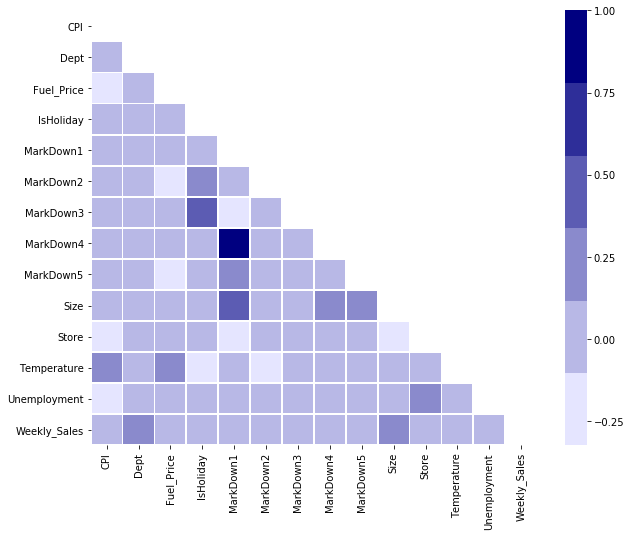

In [20]:
plot_corr(df) #plot correlation matrix of the raw dataset

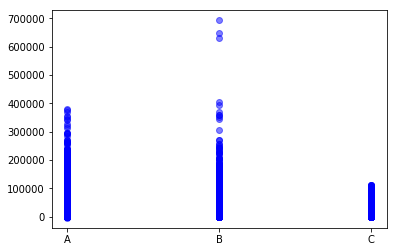

In [21]:
generate_scatter_plots(df,'Type')
# from the  graph, one key observation is type C has less sales

In [22]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Split,Store,Temperature,Type,Unemployment,Weekly_Sales
0,136.213613,2011-08-26,92,3.796,False,NaN,NaN,NaN,NaN,NaN,152513,Train,26,61.10,A,7.767,87235.57
1,128.616064,2011-03-25,22,3.480,False,NaN,NaN,NaN,NaN,NaN,158114,Train,34,53.11,A,10.398,5945.97
2,211.265543,2010-12-03,28,2.708,False,NaN,NaN,NaN,NaN,NaN,140167,Train,21,50.43,B,8.163,1219.89
3,214.878556,2010-09-17,9,2.582,False,NaN,NaN,NaN,NaN,NaN,155078,Train,8,75.32,A,6.315,11972.71
4,138.106581,2012-05-18,55,4.029,False,12613.98,NaN,11.5,1705.28,3600.79,203819,Train,19,58.81,A,8.150,8271.82


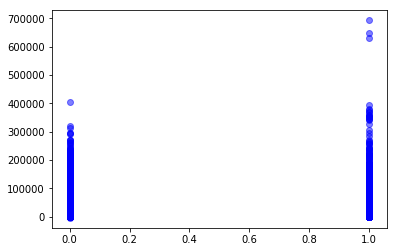

In [23]:
generate_scatter_plots(df,'IsHoliday') #sales are higher if its a holiday 

In [ ]:
#With the below plots, we will be able to see that the following features don't show too much differences (atleast not by direct data visualization)
#This is expected because the features below should not have an influence on sales (by logic)
#Commenting the below data analysis to reduce processing time

#generate_scatter_plots(df,'Temperature')
#generate_scatter_plots(df,'Fuel_Price')


In [24]:
#Lets start feature engineering
df=feature_engineer_markdown(df) #lets stark with mardown feature

In [25]:
df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)

In [26]:
# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])

In [27]:
df['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] =  df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

In [28]:
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')


In [29]:
for feature in ['IsHoliday','Pre_christmas','Black_Friday'] :
    df=add_dummies(df,feature)
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,DateType,Month,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes
0,136.213613,2011-08-26,Dept_92,3.796,IsHoliday_False,0.00,0.0,0.0,0.00,0.00,...,2011-08-26,8,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
1,128.616064,2011-03-25,Dept_22,3.480,IsHoliday_False,0.00,0.0,0.0,0.00,0.00,...,2011-03-25,3,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
2,211.265543,2010-12-03,Dept_28,2.708,IsHoliday_False,0.00,0.0,0.0,0.00,0.00,...,2010-12-03,12,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
3,214.878556,2010-09-17,Dept_9,2.582,IsHoliday_False,0.00,0.0,0.0,0.00,0.00,...,2010-09-17,9,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
4,138.106581,2012-05-18,Dept_55,4.029,IsHoliday_False,12613.98,0.0,11.5,1705.28,3600.79,...,2012-05-18,5,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0


In [30]:
#Notice anything?
df.loc[df['Weekly_Sales'] >200000,"Month"].value_counts()



11    46
12    43
2      9
4      3
8      2
5      1
6      1
3      1
10     1
9      1
Name: Month, dtype: int64

In [31]:
#Take a closer look!
#Maximum sales are from Black Friday and Christmas!!!
df.loc[df['Weekly_Sales'] >300000,"Date"].value_counts()

2010-11-26    9
2011-11-25    9
2010-12-24    2
2011-12-23    1
Name: Date, dtype: int64

In [32]:
#Now since we know the sales are so much higher on these 2 holidays, lets create additional features according to these 2 holiday periods

#for black friday we consider nov 25,26.
#for christmas we consider 23,24,25
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
#now handle these 2 new categories



In [33]:
df,medians =add_median_stats(df) #lets add the median stats for type,dept,store,month,isholiday



In [34]:
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median Sales
0,Type_A,Dept_1,Store_1,1,IsHoliday_False,16894.400
1,Type_A,Dept_1,Store_1,10,IsHoliday_False,29279.120
2,Type_A,Dept_1,Store_1,11,IsHoliday_False,19300.025
3,Type_A,Dept_1,Store_1,11,IsHoliday_True,19865.770
4,Type_A,Dept_1,Store_1,12,IsHoliday_False,44912.860


In [35]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key
0,136.213613,2011-08-26,Dept_92,3.796,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,no,no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262011-08-26IsHoliday_False
1,138.281452,2012-08-24,Dept_92,3.874,IsHoliday_False,4507.08,33.6,149.46,1866.46,4685.63,...,no,no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262012-08-24IsHoliday_False
2,136.054032,2011-08-05,Dept_92,3.903,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,no,no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262011-08-05IsHoliday_False
3,138.143774,2012-08-10,Dept_92,3.772,IsHoliday_False,5732.23,17.6,6.45,1524.63,2439.95,...,no,no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262012-08-10IsHoliday_False
4,138.185710,2012-08-17,Dept_92,3.840,IsHoliday_False,2430.95,16.0,5.54,829.70,3038.77,...,no,no,1,0,1,0,1,0,93212.89,Type_ADept_92Store_262012-08-17IsHoliday_False


In [36]:
df=add_previous_week(df) #added the last weeks date as a new variables, we will use this to get sales of previous and compare difference in later steps

In [37]:
sorted_df=create_sorted_df(df)

#Handling the newly created feature
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.set_value(index, 'LaggedSales',last['Weekly_Sales'])
        sorted_df.set_value(index, 'LaggedAvailable',1)
    else:
        sorted_df.set_value(index, 'LaggedSales',row['Median Sales']) # Fill with median
        sorted_df.set_value(index, 'LaggedAvailable',0)

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

C:\Users\Mrudula\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\Users\Mrudula\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\Users\Mrudula\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

C:\Users\Mrudula\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



0% loaded
10% loaded
20% loaded
30% loaded
40% loaded
50% loaded
60% loaded
70% loaded
80% loaded
90% loaded


In [38]:
sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,20124.22,0.00,20124.220
1,Dept_1,Store_1,2010-02-12,41513.99,46039.49,41513.990
2,Dept_1,Store_1,2010-02-19,46039.49,0.00,20124.220
3,Dept_1,Store_1,2010-02-26,20124.22,19403.54,20124.220
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,20962.245


In [39]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','DateType'])

In [40]:

df=get_sales_diff(df)

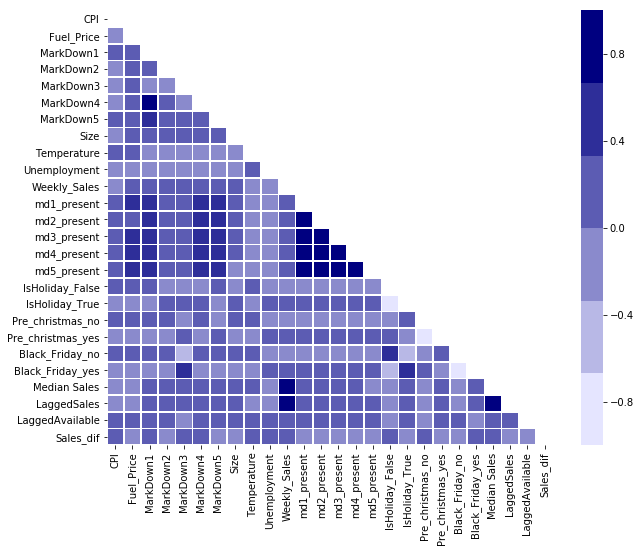

In [41]:
plot_corr(df)

In [42]:
#We have our entire dataframe ready with all the pre-processing.
#However, we do not need all these features. We did all these feature processing for us to understand the data better.
#Now, if we go all these features to the model, some of the features will be repeated. For example, month and date (We do not date if we have month) Granularity at the date level is not needed

#We create the columns we need
cols_needed = [
    'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
    
    
    
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
data_model=df[cols_needed] #we store the data for model here


In [43]:
data_model.head()

,Month,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,8,136.213613,3.796,0.00,0.0,0.00,0.00,0.00,152513,61.10,...,False,1,0,1,0,1,0,93212.89,0.00,0.0
1,8,138.281452,3.874,4507.08,33.6,149.46,1866.46,4685.63,152513,62.08,...,True,1,0,1,0,1,0,93212.89,0.00,1.0
2,8,136.054032,3.903,0.00,0.0,0.00,0.00,0.00,152513,63.16,...,False,1,0,1,0,1,0,80427.06,12785.83,1.0
3,8,138.143774,3.772,5732.23,17.6,6.45,1524.63,2439.95,152513,67.01,...,True,1,0,1,0,1,0,93890.07,-677.18,1.0
4,8,138.185710,3.840,2430.95,16.0,5.54,829.70,3038.77,152513,65.54,...,True,1,0,1,0,1,0,111812.56,-18599.67,1.0


In [44]:
X_train,X_dev,y_train,y_dev,test,train=model_dataset_split(df)

In [45]:
print(X_dev.shape)
print(y_dev.shape)

(56491, 25)
(56491,)


In [46]:
rf_model=train_RandomForest(X_train, y_train)

building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


In [47]:
y_pred_random=predict_RandomForest(X_dev,rf_model)
y_dev = y_dev.to_frame()


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


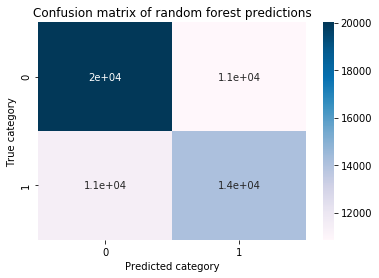

In [48]:
# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.PuBu, annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

In [49]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,Predicted
6,132.630000,2010-08-13,Dept_92,2.810,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,1,0,93212.890,Type_ADept_92Store_262010-08-13IsHoliday_False,2010-08-06,93212.890,0.0,0.000,12714.410,2316.54250
17,126.606645,2010-03-19,Dept_22,2.743,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,1,0,6325.505,Type_ADept_22Store_342010-03-19IsHoliday_False,2010-03-12,6325.505,0.0,0.000,625.475,67.50175
18,130.896645,2012-03-23,Dept_22,3.759,IsHoliday_False,3662.39,107.42,0.59,941.47,1934.93,...,1,0,6325.505,Type_ADept_22Store_342012-03-23IsHoliday_False,2012-03-16,6325.505,0.0,0.000,296.905,413.46150
27,211.064660,2010-12-24,Dept_28,2.886,IsHoliday_False,0.00,0.00,0.00,0.00,0.00,...,1,0,1340.680,Type_BDept_28Store_212010-12-24IsHoliday_False,2010-12-17,1559.650,1.0,-218.970,-341.880,-372.31425
35,226.161598,2012-09-14,Dept_9,3.717,IsHoliday_False,4678.98,0.00,12.29,1130.96,5427.34,...,1,0,13385.715,Type_ADept_9Store_82012-09-14IsHoliday_False,2012-09-07,23918.090,1.0,-10532.375,-2654.665,-4744.66350


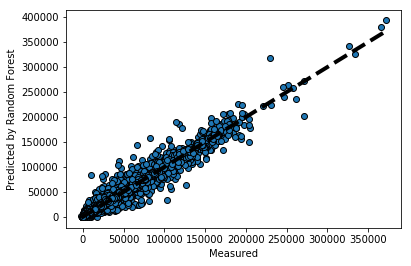

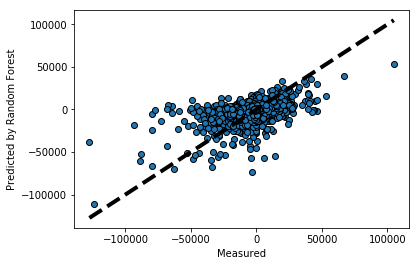

In [50]:
df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_pred_random,y_dev['Difference'].values,"Random Forest")

In [51]:
df_out = results_randomForest(y_dev,train)

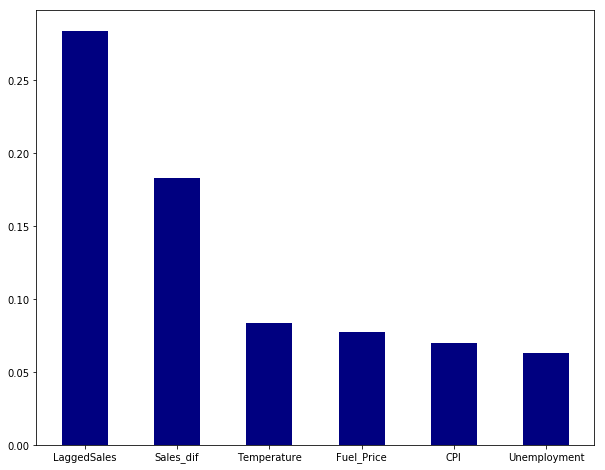

In [52]:
plot_feature_importance(data_model,cols_needed,rf_model) #get the features of top 5 significance

In [53]:
train.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,136.213613,2011-08-26,Dept_92,3.796,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,0,1,0,93212.89,Type_ADept_92Store_262011-08-26IsHoliday_False,2011-08-19,93212.89,0.0,0.00,5977.32
1,138.281452,2012-08-24,Dept_92,3.874,IsHoliday_False,4507.08,33.6,149.46,1866.46,4685.63,...,0,1,0,93212.89,Type_ADept_92Store_262012-08-24IsHoliday_False,2012-08-17,93212.89,1.0,0.00,5067.80
2,136.054032,2011-08-05,Dept_92,3.903,IsHoliday_False,0.00,0.0,0.00,0.00,0.00,...,0,1,0,93212.89,Type_ADept_92Store_262011-08-05IsHoliday_False,2011-07-29,80427.06,1.0,12785.83,-3693.64
3,138.143774,2012-08-10,Dept_92,3.772,IsHoliday_False,5732.23,17.6,6.45,1524.63,2439.95,...,0,1,0,93212.89,Type_ADept_92Store_262012-08-10IsHoliday_False,2012-08-03,93890.07,1.0,-677.18,-18599.67
4,138.185710,2012-08-17,Dept_92,3.840,IsHoliday_False,2430.95,16.0,5.54,829.70,3038.77,...,0,1,0,93212.89,Type_ADept_92Store_262012-08-17IsHoliday_False,2012-08-10,111812.56,1.0,-18599.67,0.00


In [54]:
rf_model=train_RandomForest(train[cols_needed], train['Difference'])

building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


In [55]:
final_y_prediction = rf_model.predict(test[cols_needed])

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.7s finished


In [56]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,132.661613,2010-08-20,Dept_92,2.796,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,93212.89,Type_ADept_92Store_262010-08-20IsHoliday_False,2010-08-13,80498.48,1.0,12714.41,93212.89,9708.47350,83504.41650
1,136.144129,2011-08-12,Dept_92,3.880,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,93212.89,Type_ADept_92Store_262011-08-12IsHoliday_False,2011-08-05,96906.53,1.0,-3693.64,93212.89,-807.30875,94020.19875
2,132.614193,2010-08-06,Dept_92,2.792,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,93212.89,Type_ADept_92Store_262010-08-06IsHoliday_False,2010-07-30,93212.89,0.0,0.00,93212.89,6184.95875,87027.93125
3,132.693226,2010-08-27,Dept_92,2.770,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,93212.89,Type_ADept_92Store_262010-08-27IsHoliday_False,2010-08-20,93212.89,0.0,0.00,93212.89,3488.27500,89724.61500
4,136.183129,2011-08-19,Dept_92,3.820,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,...,0,93212.89,Type_ADept_92Store_262011-08-19IsHoliday_False,2011-08-12,93212.89,0.0,0.00,93212.89,5105.00700,88107.88300
